## 0. Import the Libraries

In [1]:
import pickle
from chart_studio import plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
from datetime import datetime
from collections import Counter
import itertools
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os

from sklearn.model_selection import GridSearchCV
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from imblearn.combine import SMOTEENN

# plotly.tools.set_credentials_file(username='', api_key='')

## 1. Download, Load and Prepare Data

### Download and merge dataset

In [2]:
df_18 = pd.read_csv("./data/Chicago_Crimes_2018.csv")
df_19 = pd.read_csv("./data/Chicago_Crimes_2019.csv")
df_20 = pd.read_csv("./data/Chicago_Crimes_2020.csv")
df_21 = pd.read_csv("./data/Chicago_Crimes_2021.csv")
df_22 = pd.read_csv("./data/Chicago_Crimes_2022.csv")
df_23 = pd.read_csv("./data/Chicago_Crimes_2023.csv")
df_raw = pd.concat([df_18, df_19, df_20, df_21, df_22, df_23], ignore_index=True)

In [3]:
df_raw.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [4]:
selected_columns = ['Date', 'Latitude', 'Longitude', 'Arrest']
df = df_raw[selected_columns]

In [5]:
df.head()

,Date,Latitude,Longitude,Arrest
0,11/09/2018 12:00:00 AM,41.911574,-87.789972,False
1,09/15/2018 08:00:00 AM,NaN,NaN,True
2,09/30/2018 01:05:00 PM,41.694643,-87.661565,False
3,09/01/2018 12:00:00 AM,NaN,NaN,False
4,12/14/2018 02:45:00 PM,NaN,NaN,False


In [6]:
print("{:,} total crime records".format(len(df)))

1,373,071 total crime records


### Drop the duplicates

In [7]:
df = df.drop_duplicates()
print("{:,} total crime records after removing duplicates".format(len(df)))

1,360,210 total crime records after removing duplicates


### Break up date into components

In [8]:
def break_up_date(str_date):
    date_format = '%m/%d/%Y %I:%M:%S %p'
    date = datetime.strptime(str_date, date_format)
    return date

years = []
months = []
days = []
hours = []
minutes = []
for date in map(break_up_date,df['Date']):
    years.append(date.year)
    months.append(date.month)
    days.append(date.day)
    hours.append(date.hour)
    minutes.append(date.minute)
df['Year'] = years
df['Month'] = months
df['Day'] =  days
df['Hour'] = hours
df['Minute'] = minutes

In [11]:
df.drop('Date',axis=1,inplace=True)

### Drop NA values

In [9]:
df.dropna(axis=0,how='any', inplace=True)
print("{:,} total crime records after removing NAs".format(len(df)))

1,340,842 total crime records after removing NAs


In [10]:
df.head()
# df["Arrest"].value_counts()

,Date,Latitude,Longitude,Arrest,Year,Month,Day,Hour,Minute
0,11/09/2018 12:00:00 AM,41.911574,-87.789972,False,2018,11,9,0,0
2,09/30/2018 01:05:00 PM,41.694643,-87.661565,False,2018,9,30,13,5
10,01/01/2018 12:01:00 AM,41.998188,-87.697224,False,2018,1,1,0,1
11,09/01/2018 11:49:00 AM,41.872699,-87.688629,True,2018,9,1,11,49
16,05/01/2018 12:00:00 AM,41.764193,-87.652879,False,2018,5,1,0,0


In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Latitude,1340842.0,41.843570,0.087499,36.619446,41.767920,41.861563,41.906392,42.022671
Longitude,1340842.0,-87.669593,0.059803,-91.686566,-87.711952,-87.663048,-87.627298,-87.524529
Year,1340842.0,2020.319079,1.711073,2018.000000,2019.000000,2020.000000,2022.000000,2023.000000
Month,1340842.0,6.396638,3.301088,1.000000,4.000000,6.000000,9.000000,12.000000
Day,1340842.0,15.567696,8.856577,1.000000,8.000000,15.000000,23.000000,31.000000
Hour,1340842.0,12.782869,6.746426,0.000000,8.000000,14.000000,18.000000,23.000000
Minute,1340842.0,19.860324,18.708079,0.000000,0.000000,18.000000,33.000000,59.000000


<Figure size 3000x2000 with 0 Axes>

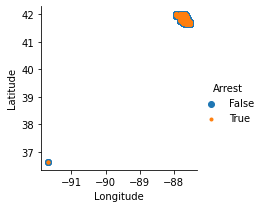

In [12]:
plt.figure(dpi=500)
sns.FacetGrid(df, hue="Arrest",hue_kws=dict(marker=["o", "."])).map(plt.scatter,"Longitude","Latitude").add_legend()
plt.show()

### Convert df data to array type

In [13]:
y = np.asarray(df[['Arrest']])
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

X = df[['Latitude','Longitude','Month','Day','Hour','Minute']]
X = X.to_dict(orient='records')
vec = DictVectorizer()
X = vec.fit_transform(X).toarray()

c:\Users\soumy\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\soumy\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



### Balancing data

In [14]:
print("Count of each target from unbalanced dataset: {} (arrest true (1) or false (0))".format(sorted(Counter(y).items())))
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
print("Count of each target from balanced dataset: {} (arrest true (1) or false (0))".format(sorted(Counter(y_resampled).items())))

Count of each target from unbalanced dataset: [(0, 1125417), (1, 215425)] (arrest true (1) or false (0))
Count of each target from balanced dataset: [(0, 668577), (1, 697274)] (arrest true (1) or false (0))


### Split data into train and test set

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.2, random_state=42)

### Normalize the input features

In [16]:
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train)
X_test2 = scaler.transform(X_test)

## 2. Grid Search Modeling, Prediction and Evaluation

### Logistic Regression

In [21]:
# parameters = { 
#     'C': np.power(10.0, np.arange(-10, 10)),
#     'solver': ['newton-cg','lbfgs','saga'],
#     'class_weight' : ['balanced','dict']
# }
# lr = LogisticRegression();
# grid_lr = GridSearchCV(estimator=lr,param_grid=parameters, verbose=0);
# grid_lr.fit(X_train, y_train);

clr = LogisticRegression().fit(X_train, y_train)


c:\Users\soumy\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning:

The line search algorithm did not converge

c:\Users\soumy\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning:

Line Search failed

c:\Users\soumy\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning:

The line search algorithm did not converge

c:\Users\soumy\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning:

Line Search failed

c:\Users\soumy\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning:

The line search algorithm did not converge

c:\Users\soumy\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning:

Line Search failed

c:\Users\soumy\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning:

The line search algorithm did not converge

c:\Users\soumy\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning:

Line Search failed

c:\U

KeyboardInterrupt: 

In [ ]:
print(grid_lr.best_params_)
print(grid_lr.best_score_)
print(grid_lr.best_estimator_)
# print(grid_lr.feature_importances_)

{'C': 1e-05, 'solver': 'saga', 'class_weight': 'dict'}
0.71687847166966
LogisticRegression(C=1e-05, class_weight='dict', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
grid_lr.best_estimator_.fit(X_train, y_train);

In [28]:
%%timeit
lr = LogisticRegression(C=1e-05, class_weight='dict', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False);
lr.fit(X_train2,y_train)
lr_expected = y_test
lr_predicted = lr.predict(X_test)
lr_cm = metrics.confusion_matrix(lr_expected, lr_predicted)

print("Accuracy={}".format(metrics.accuracy_score(lr_expected, lr_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("Logistic Regression", metrics.classification_report(lr_expected, lr_predicted)))
print("Confusion matrix:\n%s" % lr_cm)

Accuracy=0.5118735151242262


c:\Users\soumy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\soumy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\soumy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Classification report for classifier Logistic Regression:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    133342
           1       0.51      1.00      0.68    139829

    accuracy                           0.51    273171
   macro avg       0.26      0.50      0.34    273171
weighted avg       0.26      0.51      0.35    273171


Confusion matrix:
[[     0 133342]
 [     0 139829]]
Accuracy=0.5118735151242262


c:\Users\soumy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\soumy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\soumy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Classification report for classifier Logistic Regression:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    133342
           1       0.51      1.00      0.68    139829

    accuracy                           0.51    273171
   macro avg       0.26      0.50      0.34    273171
weighted avg       0.26      0.51      0.35    273171


Confusion matrix:
[[     0 133342]
 [     0 139829]]
Accuracy=0.5118735151242262


c:\Users\soumy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\soumy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\soumy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Classification report for classifier Logistic Regression:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    133342
           1       0.51      1.00      0.68    139829

    accuracy                           0.51    273171
   macro avg       0.26      0.50      0.34    273171
weighted avg       0.26      0.51      0.35    273171


Confusion matrix:
[[     0 133342]
 [     0 139829]]


KeyboardInterrupt: 

In [27]:
%%timeit
lr_expected = y_test
lr_predicted = lr.predict(X_test)
lr_cm = metrics.confusion_matrix(lr_expected, lr_predicted)

print("Accuracy={}".format(metrics.accuracy_score(lr_expected, lr_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("Logistic Regression", metrics.classification_report(lr_expected, lr_predicted)))
print("Confusion matrix:\n%s" % lr_cm)

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
plot_confusion_matrix(lr_cm,classes=[0,1],cmap=plt.cm.Blues)
plt.show()

### K-Nearest Neighbors

In [22]:
parameters = { 
    'n_neighbors':[5,7,9],
    'weights':['uniform', 'distance']
}
knn = KNeighborsClassifier();
grid_knn = GridSearchCV(estimator=knn, param_grid=parameters, verbose=0);
grid_knn.fit(X_train, y_train);

In [23]:
print(grid_knn.best_params_)
print(grid_knn.best_score_)
print(grid_knn.best_estimator_)
# print(grid_lr.feature_importances_)

{'n_neighbors': 5, 'weights': 'distance'}
0.953401727861771
KNeighborsClassifier(weights='distance')


{'n_neighbors': 5, 'weights': 'distance'}
0.8260319336773744
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

In [24]:
grid_knn.best_estimator_.fit(X_train, y_train);

In [25]:
%%timeit
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance');
knn.fit(X_train2,y_train)

knn_expected = y_test
knn_predicted = knn.predict(X_test)
knn_cm = metrics.confusion_matrix(knn_expected, knn_predicted)

print("Accuracy={}".format(metrics.accuracy_score(knn_expected, knn_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("Logistic Regression", metrics.classification_report(knn_expected, knn_predicted)))
print("Confusion matrix:\n%s" % knn_cm)
# plot_confusion_matrix(knn_cm,classes=[0,1],cmap=plt.cm.Reds)
# plt.show()

Accuracy=0.5174744024804976
Classification report for classifier Logistic Regression:
              precision    recall  f1-score   support

           0       0.89      0.01      0.03    133342
           1       0.51      1.00      0.68    139829

    accuracy                           0.52    273171
   macro avg       0.70      0.51      0.35    273171
weighted avg       0.70      0.52      0.36    273171


Confusion matrix:
[[  1743 131599]
 [   213 139616]]
Accuracy=0.5174744024804976
Classification report for classifier Logistic Regression:
              precision    recall  f1-score   support

           0       0.89      0.01      0.03    133342
           1       0.51      1.00      0.68    139829

    accuracy                           0.52    273171
   macro avg       0.70      0.51      0.35    273171
weighted avg       0.70      0.52      0.36    273171


Confusion matrix:
[[  1743 131599]
 [   213 139616]]
Accuracy=0.5174744024804976
Classification report for classifier L

In [ ]:
plot_confusion_matrix(knn_cm,classes=[0,1],cmap=plt.cm.Reds)
plt.show()

### Decision Tree

In [17]:
parameters = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2,4,5,6,7,8,9,10], 
    'min_samples_leaf':[2,4,6,8,10]
}
dt = DecisionTreeClassifier();
dt_start_time = datetime.now()
print('Start learning at {}'.format(str(dt_start_time)))
grid_dt = GridSearchCV(estimator=dt, param_grid=parameters, verbose=0);
grid_dt.fit(X_train, y_train);
dt_end_time = datetime.now() 
print('Stop learning {}'.format(str(dt_end_time)))
dt_elapsed_time= dt_end_time - dt_start_time
print('Elapsed learning {}'.format(str(dt_elapsed_time)))

Start learning at 2023-10-08 12:12:22.899996
Stop learning 2023-10-08 12:48:24.131849
Elapsed learning 0:36:01.231853


In [18]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)
print(grid_dt.best_estimator_)
# print(grid_lr.feature_importances_)

{'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 4}
0.827490207563056
DecisionTreeClassifier(max_features='auto', min_samples_leaf=10,
                       min_samples_split=4)


{'max_features': 'auto', 'min_samples_split': 7, 'min_samples_leaf': 10}
0.8439008494934109
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=7,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [19]:
grid_dt.best_estimator_.fit(X_train, y_train);

In [20]:
dt_expected = y_test
dt_start_time_test = datetime.now()
print('Start testing at {}'.format(str(dt_start_time_test)))
dt_predicted = grid_dt.best_estimator_.predict(X_test)
dt_end_time_test = datetime.now() 
print('Stop testing {}'.format(str(dt_end_time_test)))
dt_elapsed_time_test = dt_end_time_test - dt_start_time_test
print('Elapsed testing {}'.format(str(dt_elapsed_time_test)))
dt_cm = metrics.confusion_matrix(dt_expected, dt_predicted)

Start testing at 2023-10-08 12:49:35.408317
Stop testing 2023-10-08 12:49:35.529100
Elapsed testing 0:00:00.120783


In [21]:
print("Accuracy={}".format(metrics.accuracy_score(dt_expected, dt_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("Logistic Regression", metrics.classification_report(dt_expected, dt_predicted)))
print("Confusion matrix:\n%s" % dt_cm)

Accuracy=0.8269069557163827
Classification report for classifier Logistic Regression:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82    133342
           1       0.84      0.82      0.83    139829

    accuracy                           0.83    273171
   macro avg       0.83      0.83      0.83    273171
weighted avg       0.83      0.83      0.83    273171


Confusion matrix:
[[110732  22610]
 [ 24674 115155]]


In [ ]:
plot_confusion_matrix(dt_cm,classes=[0,1],cmap=plt.cm.Greens)
plt.show()

### Random Forest

In [ ]:
parameters = { 
    'criterion':['gini','entropy'],
    'n_estimators':[10,15,20,25,30],
    'min_samples_leaf':[1,2,3],
    'min_samples_split':[3,4,5,6,7]
}
rf = RandomForestClassifier();
rf_start_time = datetime.now()
print('Start learning at {}'.format(str(rf_start_time)))
grid_rf = GridSearchCV(estimator=rf, param_grid=parameters, verbose=0);
grid_rf.fit(X_train, y_train);
rf_end_time = datetime.now() 
print('Stop learning {}'.format(str(rf_end_time)))
rf_elapsed_time= rf_end_time - rf_start_time
print('Elapsed learning {}'.format(str(rf_elapsed_time)))

In [ ]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)
print(grid_rf.best_estimator_)
# print(grid_lr.feature_importances_)

{'min_samples_split': 3, 'n_estimators': 30, 'criterion': 'entropy', 'min_samples_leaf': 1}
0.8902630322595312
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
grid_rf.best_estimator_.fit(X_train, y_train);

In [ ]:
rf_expected = y_test
rf_start_time_test = datetime.now()
print('Start testing at {}'.format(str(rf_start_time_test)))
rf_predicted = grid_rf.best_estimator_.predict(X_test)
rf_end_time_test = datetime.now() 
print('Stop testing {}'.format(str(rf_end_time_test)))
rf_elapsed_time_test = rf_end_time_test - rf_start_time_test
print('Elapsed testing {}'.format(str(rf_elapsed_time_test)))
rf_cm = metrics.confusion_matrix(rf_expected, rf_predicted)

In [ ]:
print("Accuracy={}".format(metrics.accuracy_score(rf_expected, rf_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("Logistic Regression", metrics.classification_report(rf_expected, rf_predicted)))
print("Confusion matrix:\n%s" % rf_cm)

In [ ]:
plot_confusion_matrix(rf_cm,classes=[0,1],cmap=plt.cm.Greens)
plt.show()

### XG-Boost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
parameters = { 
    'max_depth' : [10],
    'n_estimators': [100,200],
    'booster': ['gbtree']
}
xgb = XGBClassifier();
xgb_start_time = datetime.now()
print('Start learning at {}'.format(str(xgb_start_time)))
grid_xgb = GridSearchCV(estimator=xgb, param_grid=parameters, verbose=0);
grid_xgb.fit(X_train, y_train);
xgb_end_time = datetime.now() 
print('Stop learning {}'.format(str(xgb_end_time)))
xgb_elapsed_time= xgb_end_time - xgb_start_time
print('Elapsed learning {}'.format(str(xgb_elapsed_time)))

In [ ]:
print(grid_xgb.best_params_)
print(grid_xgb.best_score_)
print(grid_xgb.best_estimator_)
# print(grid_xgb.feature_importances_)

{'n_estimators': 200, 'max_depth': 10, 'booster': 'gbtree'}
0.9251559172785899
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [ ]:
grid_xgb.best_estimator_.fit(X_train2, y_train2);

In [ ]:
xgb = XGBClassifier(n_estimators=200,max_depth=10,booster='gbtree');
xgb.fit(X_train2, y_train);
xgb_expected = y_test
xgb_predicted = xgb.predict(X_test2)
xgb_cm = metrics.confusion_matrix(xgb_expected, xgb_predicted)

In [ ]:
xgb_expected = y_test
xgb_start_time_test = datetime.now()
print('Start testing at {}'.format(str(xgb_start_time_test)))
xgb_predicted = xgb.predict(X_test2)
xgb_end_time_test = datetime.now() 
print('Stop testing {}'.format(str(xgb_end_time_test)))
xgb_elapsed_time_test = xgb_end_time_test - xgb_start_time_test
print('Elapsed testing {}'.format(str(xgb_elapsed_time_test)))
xgb_cm = metrics.confusion_matrix(xgb_expected, xgb_predicted)

In [ ]:
print("Accuracy={}".format(metrics.accuracy_score(xgb_expected, xgb_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("XG-Boost", metrics.classification_report(xgb_expected, xgb_predicted)))
print("Confusion matrix:\n%s" % xgb_cm)

In [ ]:
plt.figure(dpi=300)
plot_confusion_matrix(xgb_cm,classes=[0,1],cmap=plt.cm.Greys,normalize=True)
plt.show()

### Support Vector Machine

In [ ]:
# parameters = { 
#     'C': [6], 
#     'kernel': ['linear','rbf']
# }
# svm = SVC();
# svm_start_time = datetime.now()
# print('Start learning at {}'.format(str(svm_start_time)))
# grid_svm = GridSearchCV(estimator=svm, param_grid=parameters, verbose=0);
# grid_svm.fit(X_train, y_train);
# svm_end_time = datetime.now() 
# print('Stop learning {}'.format(str(svm_end_time)))
# svm_elapsed_time= svm_end_time - svm_start_time
# print('Elapsed learning {}'.format(str(svm_elapsed_time)))

In [ ]:
print(grid_svm.best_params_)
print(grid_svm.best_score_)
print(grid_svm.best_estimator_)
# print(grid_xgb.feature_importances_)

In [ ]:
grid_svm.best_estimator_.fit(X_train, y_train);

In [ ]:
svm_expected = y_test
svm_start_time_test = datetime.now()
print('Start testing at {}'.format(str(svm_start_time_test)))
svm_predicted = grid_svm.best_estimator_.predict(X_test)
svm_end_time_test = datetime.now() 
print('Stop testing {}'.format(str(svm_end_time_test)))
svm_elapsed_time_test = svm_end_time_test - svm_start_time_test
print('Elapsed testing {}'.format(str(svm_elapsed_time_test)))
svm_cm = metrics.confusion_matrix(svm_expected, svm_predicted)

In [ ]:
print("Accuracy={}".format(metrics.accuracy_score(svm_expected, svm_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("Logistic Regression", metrics.classification_report(svm_expected, svm_predicted)))
print("Confusion matrix:\n%s" % svm_cm)

In [ ]:
plot_confusion_matrix(svm_cm,classes=[0,1],cmap=plt.cm.Greens)
plt.show()

### Gaussian Naive Bayes

In [ ]:
nb = GaussianNB();
nb_start_time = datetime.now()
print('Start learning at {}'.format(str(nb_start_time)))
# grid_nb = GridSearchCV(estimator=nb, param_grid=parameters, verbose=0);
nb.fit(X_train, y_train);
nb_end_time = datetime.now() 
print('Stop learning {}'.format(str(nb_end_time)))
nb_elapsed_time= nb_end_time - nb_start_time
print('Elapsed learning {}'.format(str(nb_elapsed_time)))

In [ ]:
print(grid_svm.best_params_)
print(grid_svm.best_score_)
print(grid_svm.best_estimator_)
# print(grid_xgb.feature_importances_)

In [ ]:
# grid_nb.best_estimator_.fit(X_train, y_train);

In [ ]:
nb_expected = y_test
nb_start_time_test = datetime.now()
print('Start testing at {}'.format(str(nb_start_time_test)))
nb_predicted = nb.predict(X_test)
nb_end_time_test = datetime.now() 
print('Stop testing {}'.format(str(nb_end_time_test)))
nb_elapsed_time_test = nb_end_time_test - nb_start_time_test
print('Elapsed testing {}'.format(str(nb_elapsed_time_test)))
nb_cm = metrics.confusion_matrix(nb_expected, nb_predicted)

In [ ]:
print("Accuracy={}".format(metrics.accuracy_score(nb_expected, nb_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("Logistic Regression", metrics.classification_report(nb_expected, nb_predicted)))
print("Confusion matrix:\n%s" % nb_cm)

In [ ]:
plot_confusion_matrix(nb_cm,classes=[0,1],cmap=plt.cm.Greens)
plt.show()

## 3. Testing

In [ ]:
Test = [16 5 41.876248 -87.653065 10 5]

In [ ]:
print(grid_xgb.best_estimator_.predict(X_test))

In [ ]:
Test = np.array([[ 21.        ,   0.        ,  42.0122934 , -87.69971411,
        15.        ,   9.        ]])
print(scaler.transform(Test))
Test2 = np.array([[-0.50714446,  0.70064672,  1.33995114, -1.07622397, -1.12694646, -0.47388072]])
scaler.transform(Test2)
print(xgb.predict(Test2))
print(xgb.predict_proba(Test2))

In [ ]:
Test = np.array([[ 21.        ,   0.        ,  42.0122934 , -87.69971411,15.        ,   9.        ]])
# print(xgb.predict(scaler.transform[Test]))
print(xgb.predict_proba(scaler.transform(Test)))

In [ ]:
pickle.dump(scaler, open('./scaler.pkl', 'wb'))
pickle.dump(xgb, open('./xgboost.pkl', 'wb'))

In [ ]:
pickle.load(open('./scaler.pkl', 'rb'))

In [ ]:
!pwd

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Arrest Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')